データの読み込みと前処理を行うためのnotebookです。  
モデルの学習と予測にはここで処理をかけたデータを利用するようにして下さい。

## 0. 必要なライブラリのimport

In [64]:
import warnings
import time
import sys
import datetime

import numpy as np
import pandas as pd

warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. merchants以外のデータの読み込み

In [65]:
def reduce_mem_usage(df, verbose=True):
    """
    データフレームのメモリ使用量を減らす。
    
    Parameters
    ----------
    df : pd.DataFrame
        メモリ使用量を削減したいデータフレーム。
    verbose : bool, optional
        メモリ使用量の削減結果を出力するかどうか（デフォルトは True）。

    Returns
    -------
    pd.DataFrame
        メモリ使用量が削減されたデータフレーム。
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def binarize(df):
    """
    指定された列を二値化する。

    Parameters
    ----------
    df : pd.DataFrame
        二値化対象のデータフレーム。

    Returns
    -------
    pd.DataFrame
        二値化されたデータフレーム。
    """

    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y': 1, 'N': 0})
    return df

def read_data(input_file):
    """
    指定されたファイルからデータを読み込み、前処理を行う。

    Parameters
    ----------
    input_file : str
        読み込むデータファイルのパス。

    Returns
    -------
    pd.DataFrame
        前処理されたデータフレーム。
    """
    
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (pd.Timestamp('2018-02-01') - df['first_active_month']).dt.days
    return df

In [66]:
train = read_data('../data/row/train.csv')
test = read_data('../data/row/test.csv')

new_transactions = pd.read_csv('../data/row/new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('../data/row/historical_transactions.csv',
                                      parse_dates=['purchase_date'])

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

## 2. merchantsの読み込み

In [67]:
def binarize_merchants(df):
    """
    指定された列を二値化する。

    Parameters
    ----------
    df : pd.DataFrame
        二値化対象のデータフレーム。

    Returns
    -------
    pd.DataFrame
        二値化されたデータフレーム。
    """

    for col in ['category_1', 'category_4']:
        df[col] = df[col].map({'Y': 1, 'N': 0})
    return df

In [68]:
merchants = pd.read_csv('../data/row/merchants.csv')
merchants = binarize_merchants(merchants)

In [69]:
historical_transactions = reduce_mem_usage(historical_transactions)
merchants = reduce_mem_usage(merchants)

Mem. usage decreased to 1415.95 Mb (54.5% reduction)
Mem. usage decreased to 27.77 Mb (50.6% reduction)


## merchant_idが重複している（確認したいときに見るだけ）

In [8]:
duplicates = merchants[merchants.duplicated(subset='merchant_id', keep=False)]
duplicates_id_series = duplicates['merchant_id'].drop_duplicates()
print(f"uplicates_count: {len(duplicates)}")
print(f"uplicates_id_series: {len(duplicates_id_series)}")


uplicates_count: 104
uplicates_id_series: 41


In [10]:
## 4%程のデータが重複のあるmerchant_idの店での取引
#len(historical_transactions)
#len(historical_transactions.query('merchant_id in @duplicates_series'))
1196961/29112361

0.04111521562953963

In [9]:
# 実際の重複している加盟店データ
# 複合キーで一意になっているという感じでもない
pd.set_option('display.max_columns', None)
duplicates

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
53,M_ID_c0b712e11a,35,823,25,-0.057465,-0.057465,0,E,E,1.00,1.000000,1,1.00,1.000000,1,1.00,1.000000,1,0,231,9,1.0
54,M_ID_c0b712e11a,35,823,25,-0.007896,-0.007896,0,E,E,1.01,0.950617,3,1.01,1.097119,6,1.20,1.190741,12,0,231,9,1.0
111,M_ID_0039220eb3,35,836,5,-0.057465,-0.057465,1,E,E,0.66,0.666667,3,0.66,0.666667,3,0.66,0.666667,3,1,-1,-1,NaN
112,M_ID_0039220eb3,35,836,5,0.408447,0.408447,1,C,D,1.17,1.109649,3,1.17,1.087939,6,1.19,0.997021,12,1,-1,-1,NaN
3392,M_ID_bd49e37dda,35,692,21,-0.057465,-0.057465,0,E,E,60.09,9.333333,3,104.82,13.800000,5,104.82,13.800000,5,0,51,16,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333906,M_ID_6464db3b45,35,210,35,-0.057465,-0.057465,1,A,C,0.79,0.781268,3,0.63,0.643325,6,0.42,0.402207,12,1,-1,-1,NaN
334070,M_ID_1802942aaf,35,302,22,-0.047546,-0.047546,0,A,B,0.94,0.954538,3,0.85,0.868956,6,0.57,0.603051,12,0,96,9,1.0
334071,M_ID_1802942aaf,72963,302,22,-0.047546,-0.047546,0,A,B,0.94,0.954538,3,0.85,0.868956,6,0.57,0.603051,12,0,96,9,1.0
334072,M_ID_1802942aaf,35,302,22,-0.027725,-0.027725,0,A,C,1.01,1.064999,3,0.98,1.102663,6,0.97,1.269495,12,0,96,9,1.0


In [11]:
merchants

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,0,E,E,-0.400000,9.666667,3,-2.250000,18.666667,6,-2.320000,13.916667,12,0,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,0,E,E,-0.720000,1.750000,3,-0.740000,1.291667,6,-0.570000,1.687500,12,0,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,0,E,E,-82.129997,260.000000,2,-82.129997,260.000000,2,-82.129997,260.000000,2,0,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,1,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,1,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,1,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,1,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334691,M_ID_1f4773aa76,1145,705,33,3.173828,-0.047546,0,A,A,1.000000,1.022618,3,0.990000,1.019505,6,1.000000,1.024796,12,1,69,9,1.0
334692,M_ID_725a60d404,35,544,29,-0.057465,-0.057465,1,A,A,0.890000,0.927684,3,0.780000,0.813473,6,0.590000,0.606765,12,1,-1,-1,NaN
334693,M_ID_f2045dd267,35,561,7,-0.057465,-0.057465,0,A,A,0.960000,0.982957,3,0.900000,0.924769,6,0.740000,0.750763,8,1,160,21,5.0
334694,M_ID_9139332ccc,35,511,7,-0.057465,-0.057465,1,A,A,0.940000,0.919558,3,0.820000,0.783000,6,0.650000,0.584000,12,1,-1,-1,NaN


In [9]:
# 数値は平均、カテゴリは先頭をとって重複していたmerchant_idを一意にする
# まず集約せずに結合する。行が増える

merchants = merchants.groupby('merchant_id').agg({
    'merchant_group_id': 'first',
    'merchant_category_id': 'first',
    'subsector_id': 'first',
    'numerical_1': 'mean',
    'numerical_2': 'mean',
    'category_1': 'first',
    'most_recent_sales_range': 'first',
    'most_recent_purchases_range': 'first',
    'avg_sales_lag3': 'mean',
    'avg_purchases_lag3': 'mean',
    'active_months_lag3': 'mean',
    'avg_sales_lag6': 'mean',
    'avg_purchases_lag6': 'mean',
    'active_months_lag6': 'mean',
    'avg_sales_lag12': 'mean',
    'avg_purchases_lag12': 'mean',
    'active_months_lag12': 'mean',
    'category_4': 'first',
    'city_id': 'first',
    'state_id': 'first',
    'category_2': 'first'
}).reset_index()

In [29]:
merchants

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_000025127f,14602,80,37,-0.057465,-0.057465,0,E,E,1.29,1.880342,3.0,1.26,2.228632,6.0,1.08,2.089744,12.0,1,69,9,1.0
1,M_ID_0000699140,19420,87,27,-0.057465,-0.057465,0,D,D,0.99,0.997832,3.0,1.04,1.002168,6.0,1.24,1.154878,12.0,0,48,9,1.0
2,M_ID_00006a5552,52848,178,29,-0.057465,-0.057465,0,E,E,1.21,1.000000,3.0,1.18,1.000000,6.0,1.22,1.035714,12.0,0,64,15,1.0
3,M_ID_000087311e,44655,206,1,-0.057465,-0.057465,1,D,E,0.93,1.314815,3.0,0.95,1.300926,6.0,0.78,1.261574,12.0,1,-1,-1,NaN
4,M_ID_0000ab0b2d,35761,367,16,-0.057465,-0.057465,0,D,D,1.05,1.089897,3.0,0.99,1.057279,6.0,1.06,1.135640,12.0,0,-1,9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334628,M_ID_fffeeb852d,35,33,29,0.031769,0.031769,0,D,D,0.72,1.016340,3.0,0.81,1.125817,6.0,0.75,1.077206,12.0,0,13,9,1.0
334629,M_ID_fffef87522,35,409,29,0.051605,0.051605,0,E,E,1.28,1.728070,3.0,1.34,1.879825,6.0,1.45,1.914846,12.0,0,271,9,1.0
334630,M_ID_ffff0af8e7,4739,278,37,-0.057465,-0.057465,0,D,D,0.90,0.909420,3.0,0.91,0.935990,6.0,1.07,1.147343,12.0,0,62,9,1.0
334631,M_ID_ffff655e2c,105563,215,21,-0.057465,-0.057465,0,D,E,0.61,0.788889,3.0,0.55,0.772222,6.0,0.44,0.650000,12.0,0,289,5,5.0


In [7]:
prefix = 'merchant_'
merchants.columns = [col if col.startswith(prefix) else prefix + col for col in merchants.columns]

In [23]:
merchants.head(5)

,merchant_id,merchant_group_id,merchant_category_id,merchant_subsector_id,merchant_numerical_1,merchant_numerical_2,merchant_category_1,merchant_most_recent_sales_range,merchant_most_recent_purchases_range,merchant_avg_sales_lag3,...,merchant_avg_sales_lag6,merchant_avg_purchases_lag6,merchant_active_months_lag6,merchant_avg_sales_lag12,merchant_avg_purchases_lag12,merchant_active_months_lag12,merchant_category_4,merchant_city_id,merchant_state_id,merchant_category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,0,E,E,-0.400000,...,-2.250000,18.666667,6,-2.320000,13.916667,12,0,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,0,E,E,-0.720000,...,-0.740000,1.291667,6,-0.570000,1.687500,12,0,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,0,E,E,-82.129997,...,-82.129997,260.000000,2,-82.129997,260.000000,2,0,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,1,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,1,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,1,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,1,-1,-1,NaN


In [8]:
history_merchant = pd.merge(historical_transactions, merchants, on = 'merchant_id', how = 'left')

In [9]:
history_merchant = reduce_mem_usage(history_merchant)

Mem. usage decreased to 4483.92 Mb (20.5% reduction)


In [10]:
len(history_merchant)

30333780

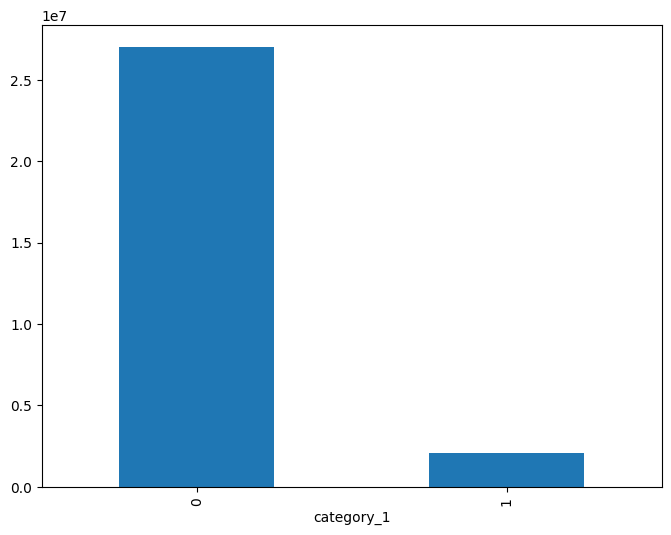

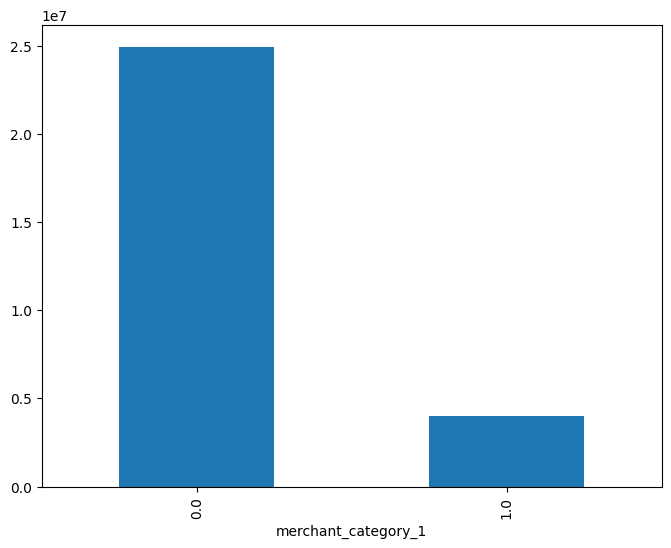

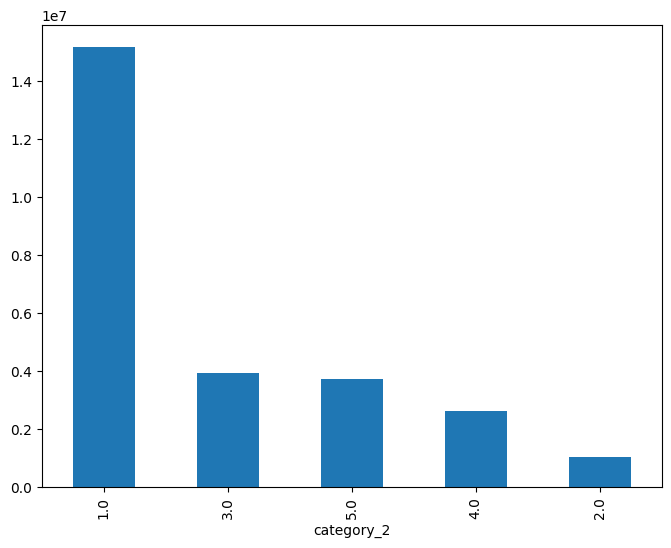

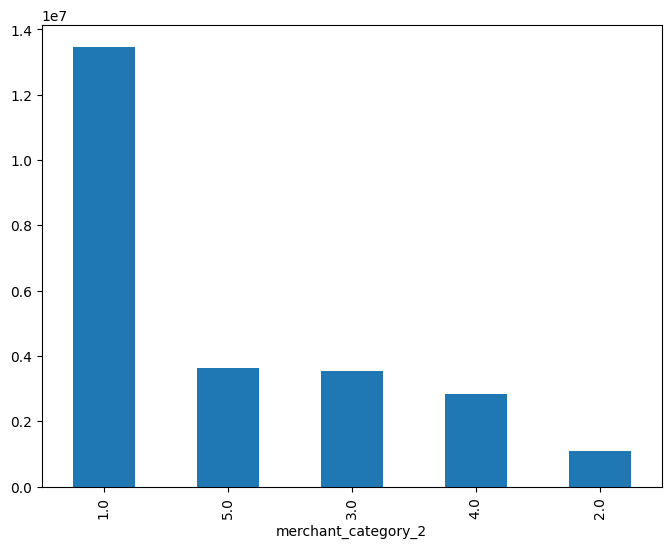

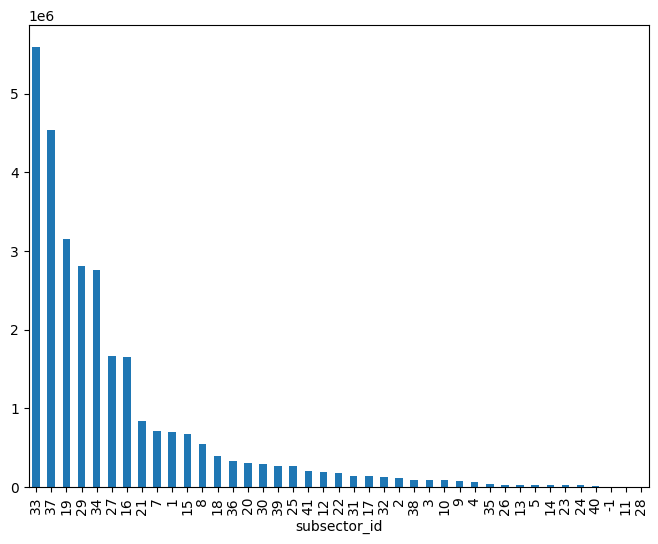

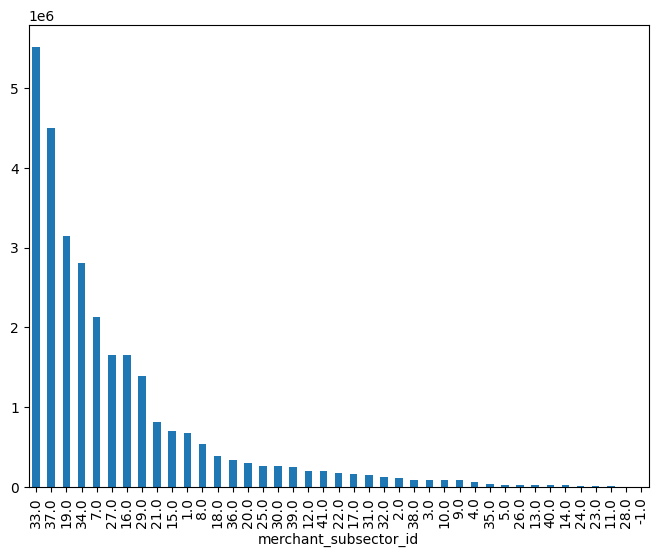

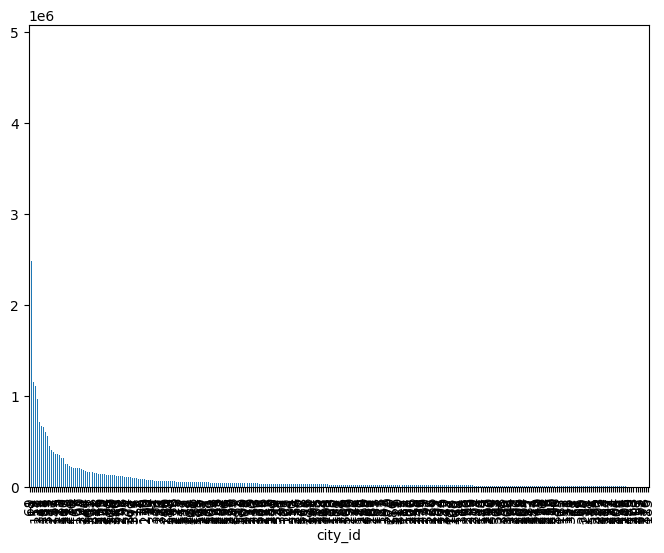

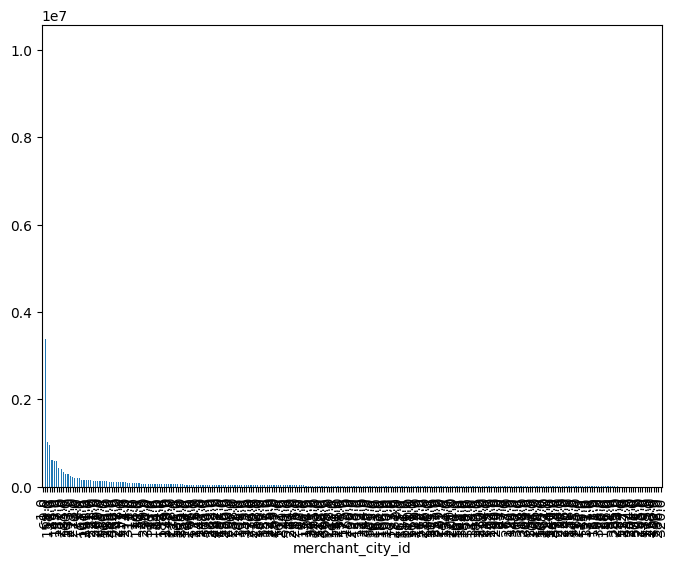

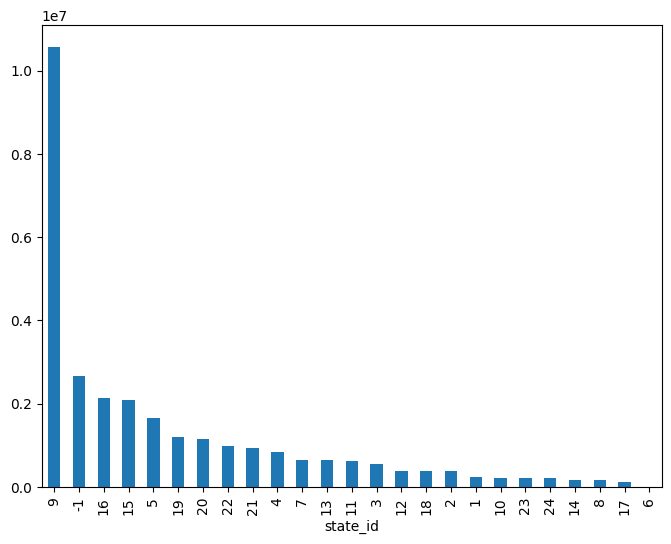

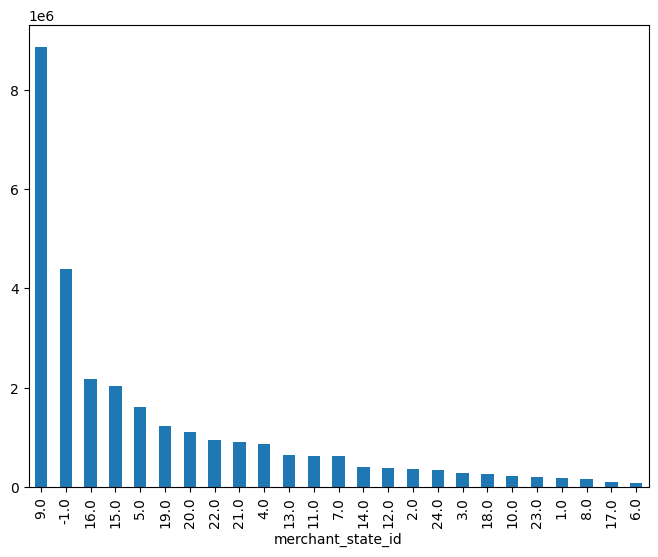

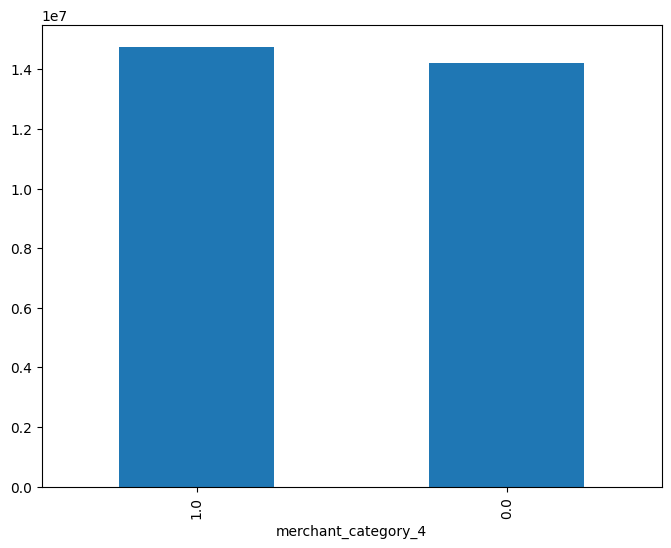

In [15]:
import matplotlib.pyplot as plt
for column in history_merchant[['category_1', 'merchant_category_1', 'category_2', 'merchant_category_2', 'subsector_id', 'merchant_subsector_id', 'city_id', 'merchant_city_id', 'state_id', 'merchant_state_id', 'merchant_category_4']].columns:
    count_data = history_merchant[['category_1', 'merchant_category_1', 'category_2', 'merchant_category_2', 'subsector_id', 'merchant_subsector_id', 'city_id', 'merchant_city_id', 'state_id', 'merchant_state_id', 'merchant_category_4']][column].value_counts()
    plt.figure(figsize=(8, 6))
    count_data.plot(kind='bar')

In [40]:
history_merchant[['category_1', 'merchant_category_1', 'category_2', 'merchant_category_2', 'subsector_id', 'merchant_subsector_id', 'city_id', 'merchant_city_id', 'state_id', 'merchant_state_id', 'merchant_category_4']].head(40)
# subsecterが異なるものがあるが、これらの共通するカラムの一致率が高い店データを結合するのは一つの方法
# merchantsを一意に結合後-1やNaNとなっているデータは互いに補完できそう

,category_1,merchant_category_1,category_2,merchant_category_2,subsector_id,merchant_subsector_id,city_id,merchant_city_id,state_id,merchant_state_id,merchant_category_4
0,0,0.0,1.0,1.0,37,37.0,88,88.0,16,16.0,1.0
1,0,0.0,1.0,1.0,16,16.0,88,88.0,16,16.0,1.0
2,0,0.0,1.0,1.0,37,37.0,88,88.0,16,16.0,1.0
3,0,0.0,1.0,1.0,34,34.0,88,88.0,16,16.0,1.0
4,0,0.0,1.0,1.0,37,37.0,88,88.0,16,16.0,1.0
5,0,0.0,1.0,1.0,37,37.0,333,333.0,9,9.0,0.0
6,0,0.0,1.0,1.0,37,37.0,88,88.0,16,16.0,1.0
7,0,0.0,1.0,1.0,37,37.0,3,3.0,16,16.0,0.0
8,0,0.0,1.0,1.0,37,37.0,88,88.0,16,16.0,1.0
9,0,0.0,1.0,1.0,37,37.0,88,88.0,16,16.0,1.0


## 3. 関連度の高い重複データを選択して結合するまで

In [70]:
len(historical_transactions)

29112361

In [71]:
def binarize_merchants(df):
    """
    指定された列を二値化する。

    Parameters
    ----------
    df : pd.DataFrame
        二値化対象のデータフレーム。

    Returns
    -------
    pd.DataFrame
        二値化されたデータフレーム。
    """

    for col in ['category_1', 'category_4']:
        df[col] = df[col].map({'Y': 1, 'N': 0})
    return df

merchants = pd.read_csv('../data/row/merchants.csv')
merchants = binarize_merchants(merchants)
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)
merchants = reduce_mem_usage(merchants)
merchants = merchants.replace([np.inf, -np.inf], np.nan)

prefix = 'merchant_'
merchants.columns = [col if col.startswith(prefix) else prefix + col for col in merchants.columns]


Mem. usage decreased to 1415.95 Mb (0.0% reduction)
Mem. usage decreased to 95.48 Mb (54.5% reduction)
Mem. usage decreased to 27.77 Mb (50.6% reduction)


In [72]:
historical_transactions = historical_transactions.assign(Index = historical_transactions.index)
history_merchant = pd.merge(historical_transactions, merchants, on = 'merchant_id', how = 'left')
history_merchant = reduce_mem_usage(history_merchant)

Mem. usage decreased to 4252.50 Mb (27.6% reduction)


In [73]:
new_transactions = new_transactions.assign(Index = new_transactions.index)
new_merchant = pd.merge(new_transactions, merchants, on = 'merchant_id', how = 'left')
new_merchant = reduce_mem_usage(new_merchant)

Mem. usage decreased to 279.66 Mb (27.6% reduction)


In [74]:
pd.set_option('display.max_columns', None)
history_merchant

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id_x,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,Index,merchant_group_id,merchant_category_id_y,merchant_subsector_id,merchant_numerical_1,merchant_numerical_2,merchant_category_1,merchant_most_recent_sales_range,merchant_most_recent_purchases_range,merchant_avg_sales_lag3,merchant_avg_purchases_lag3,merchant_active_months_lag3,merchant_avg_sales_lag6,merchant_avg_purchases_lag6,merchant_active_months_lag6,merchant_avg_sales_lag12,merchant_avg_purchases_lag12,merchant_active_months_lag12,merchant_category_4,merchant_city_id,merchant_state_id,merchant_category_2
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,0,35.0,80.0,37.0,23.470598,23.014511,0.0,A,A,1.08,1.082451,3.0,1.14,1.114136,6.0,1.19,1.156844,12.0,1.0,88.0,16.0,1.0
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,1,2084.0,367.0,16.0,1.092658,-0.057471,0.0,A,A,1.06,1.052071,3.0,1.06,1.058605,6.0,1.05,1.062087,12.0,1.0,88.0,16.0,1.0
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2,27369.0,80.0,37.0,0.021849,0.021849,0.0,C,C,0.98,0.974653,3.0,0.98,0.967058,6.0,0.97,0.956668,12.0,1.0,88.0,16.0,1.0
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,3,24104.0,560.0,34.0,-0.057471,-0.057471,0.0,D,C,1.00,1.053443,3.0,0.88,0.897406,6.0,0.86,0.864394,12.0,1.0,88.0,16.0,1.0
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,4,35.0,80.0,37.0,23.470598,23.014511,0.0,A,A,1.08,1.082451,3.0,1.14,1.114136,6.0,1.19,1.156844,12.0,1.0,88.0,16.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30333775,1,C_ID_2863d2fa95,-1,1,1,B,360,M_ID_edd92b6720,-1,-0.632706,2017-01-20 08:52:04,NaN,-1,34,29112356,86697.0,360.0,34.0,-0.057471,-0.057471,1.0,B,C,1.02,0.964327,3.0,0.90,0.887713,6.0,0.87,0.879084,12.0,1.0,-1.0,-1.0,NaN
30333776,1,C_ID_2863d2fa95,-1,1,1,B,360,M_ID_edd92b6720,0,-0.632706,2017-02-20 04:40:50,NaN,-1,34,29112357,86697.0,360.0,34.0,-0.057471,-0.057471,1.0,B,C,1.02,0.964327,3.0,0.90,0.887713,6.0,0.87,0.879084,12.0,1.0,-1.0,-1.0,NaN
30333777,1,C_ID_5c240d6e3c,3,0,0,A,278,M_ID_9cdcfe8673,0,-0.657740,2017-12-26 18:37:51,1.0,16,37,29112358,15036.0,80.0,37.0,-0.057471,-0.057471,0.0,D,C,0.88,0.912826,3.0,0.87,0.869572,6.0,0.89,0.853290,12.0,0.0,3.0,16.0,1.0
30333778,1,C_ID_5c240d6e3c,331,0,0,A,514,M_ID_1a75f94f92,-1,0.770620,2017-11-24 14:18:15,1.0,16,9,29112359,35.0,514.0,9.0,0.666317,0.656402,0.0,C,D,0.89,0.934571,3.0,1.11,1.000442,6.0,1.02,0.947032,12.0,0.0,-1.0,16.0,1.0


In [75]:
len(history_merchant)

30333780

In [76]:
# 一致数のカラムを追加して初期化
history_merchant['relation'] = 0

# カラムペアのリストを作成:'category_1', 'merchant_category_1', 'category_2', 'merchant_category_2', 'subsector_id', 'merchant_subsector_id', 'city_id', 'merchant_city_id', 'state_id', 'merchant_state_id'
column_pairs = [('category_1', 'merchant_category_1'),
                ('category_2', 'merchant_category_2'),
                ('subsector_id', 'merchant_subsector_id'),
                ('city_id', 'merchant_city_id'),
                ('state_id', 'merchant_state_id')]
# 各行に対してカラムペアの一致数を計算:
# for index, row in history_merchant.iterrows():
#     relation_count = 0

#     for trans_col, merch_col in column_pairs:
#         if row[trans_col] == row[merch_col]:
#             relation_count += 1
#         else:
#             pass
#     history_merchant.at[index, 'relation'] = relation_count

history_merchant['relation'] = sum(history_merchant[trans_col] == history_merchant[merch_col] for trans_col, merch_col in column_pairs)

In [77]:
# 一致数のカラムを追加して初期化
new_merchant['relation'] = 0

# カラムペアのリストを作成:'category_1', 'merchant_category_1', 'category_2', 'merchant_category_2', 'subsector_id', 'merchant_subsector_id', 'city_id', 'merchant_city_id', 'state_id', 'merchant_state_id'
column_pairs = [('category_1', 'merchant_category_1'),
                ('category_2', 'merchant_category_2'),
                ('subsector_id', 'merchant_subsector_id'),
                ('city_id', 'merchant_city_id'),
                ('state_id', 'merchant_state_id')]

new_merchant['relation'] = sum(new_merchant[trans_col] == new_merchant[merch_col] for trans_col, merch_col in column_pairs)

In [78]:
history_merchant['relation'].value_counts()

relation
5    17935218
4     7314195
0     2213542
2      985726
1      969249
3      915850
Name: count, dtype: int64

In [79]:
# groupby と idxmax を使って relation カラムが最大の行のインデックスを取得する
idx_to_keep = history_merchant.groupby(['Index'])['relation'].idxmax()

# それ以外の行を削除する
history_merchant.drop(history_merchant.index.difference(idx_to_keep), inplace=True)

In [80]:
# groupby と idxmax を使って relation カラムが最大の行のインデックスを取得する
idx_to_keep = new_merchant.groupby(['Index'])['relation'].idxmax()

# それ以外の行を削除する
new_merchant.drop(new_merchant.index.difference(idx_to_keep), inplace=True)


In [81]:
# Index列の削除
history_merchant = history_merchant.drop(columns=['Index'])
new_merchant = new_merchant.drop(columns=['Index'])

In [82]:
history_merchant['relation'].value_counts()

relation
5    17869722
4     7275555
0     1225213
2      985576
1      891168
3      865127
Name: count, dtype: int64

In [83]:
len(history_merchant)

29112361

### 特徴量作成

## 読み込み後に先頭行と平均で重複削除から結合までの処理をまとめたもの（レガシーデータ。実行しないで）

In [33]:
# 数値は平均、カテゴリは先頭をとって重複していたmerchant_idを一意にする
merchants = merchants.groupby('merchant_id').agg({
    'merchant_group_id': 'first',
    'merchant_category_id': 'first',
    'subsector_id': 'first',
    'numerical_1': 'mean',
    'numerical_2': 'mean',
    'category_1': 'first',
    'most_recent_sales_range': 'first',
    'most_recent_purchases_range': 'first',
    'avg_sales_lag3': 'mean',
    'avg_purchases_lag3': 'mean',
    'active_months_lag3': 'mean',
    'avg_sales_lag6': 'mean',
    'avg_purchases_lag6': 'mean',
    'active_months_lag6': 'mean',
    'avg_sales_lag12': 'mean',
    'avg_purchases_lag12': 'mean',
    'active_months_lag12': 'mean',
    'category_4': 'first',
    'city_id': 'first',
    'state_id': 'first',
    'category_2': 'first'
}).reset_index()
prefix = 'merchant_'
merchants.columns = [col if col.startswith(prefix) else prefix + col for col in merchants.columns]
history_merchant = pd.merge(historical_transactions, merchants, on = 'merchant_id', how = 'left')
history_merchant = reduce_mem_usage(history_merchant)

# 補完は無視してひとまず重複するmerchant側のカラムを消す
history_merchant = history_merchant.drop(columns = ['merchant_category_1', 'merchant_category_2', 'merchant_subsector_id', 'merchant_city_id', 'merchant_state_id', 'merchant_category_id_y'])

Mem. usage decreased to 4303.38 Mb (20.5% reduction)


## 4. 最終的なデータ作成

In [84]:
def calculate_month_diff(transactions):
    """
    purchase_dateとmonth_lagを基にmonth_diffを計算する。
    
    Parameters
    ----------
    transactions : pd.DataFrame
        取引データのデータフレーム。
    
    Returns
    -------
    pd.DataFrame
        month_diff列が追加されたデータフレーム。
    """
    current_date = pd.Timestamp(datetime.datetime.today())
    transactions['month_diff'] = ((current_date - transactions['purchase_date']).dt.days) // 30
    transactions['month_diff'] += transactions['month_lag']
    return transactions


def encode_categorical_columns(df, columns):
    """
    指定されたカテゴリカル列をワンホットエンコーディングする。
    
    Parameters
    ----------
    df : pd.DataFrame
        エンコード対象のデータフレーム。
    columns : list of str
        エンコードするカテゴリカル列のリスト。
    
    Returns
    -------
    pd.DataFrame
        ワンホットエンコードされたデータフレーム。
    """
    return pd.get_dummies(df, columns=columns, dummy_na=True)


def reduce_mem_usage(df, verbose=True):
    """
    データフレームのメモリ使用量を減らす。

    Parameters
    ----------
    df : pd.DataFrame
        メモリ使用量を削減したいデータフレーム。
    verbose : bool, optional
        メモリ使用量の削減結果を出力するかどうか（デフォルトは True）。

    Returns
    -------
    pd.DataFrame
        メモリ使用量が削減されたデータフレーム。
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def aggregate_transactions(history):
    """
    取引データを集計する。
    
    Parameters
    ----------
    history : pd.DataFrame
        取引データのデータフレーム。
    
    Returns
    -------
    pd.DataFrame
        集計されたデータフレーム。
    """
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id_x': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['mean', 'max', 'min', 'std'],
        'month_diff': ['mean'],
        'merchant_group_id': ['nunique'],
        'merchant_numerical_1': ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_numerical_2': ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_avg_sales_lag3': ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_avg_purchases_lag3': ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_active_months_lag3': ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_avg_sales_lag6': ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_avg_purchases_lag6': ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_active_months_lag6': ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_avg_sales_lag12': ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_avg_purchases_lag12': ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_active_months_lag12': ['sum', 'mean', 'max', 'min', 'std'],

    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history


def aggregate_per_month(history):
    """
    月ごとの取引データを集計する。
    
    Parameters
    ----------
    history : pd.DataFrame
        取引データのデータフレーム。
    
    Returns
    -------
    pd.DataFrame
        月ごとに集計されたデータフレーム。
    """
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
        'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
        'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
    }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group


def successive_aggregates(df, field1, field2):
    """
    指定されたフィールドを基に連続集計を行う。
    
    Parameters
    ----------
    df : pd.DataFrame
        取引データのデータフレーム。
    field1 : str
        集計の基準となるフィールド。
    field2 : str
        集計されるフィールド。
    
    Returns
    -------
    pd.DataFrame
        連続集計されたデータフレーム。
    """
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u


In [85]:
history_merchant = reduce_mem_usage(history_merchant)
new_merchant = reduce_mem_usage(new_merchant)

Mem. usage decreased to 4220.08 Mb (1.9% reduction)
Mem. usage decreased to 284.56 Mb (1.9% reduction)


In [86]:
# データ準備
history_merchant['purchase_date'] = pd.to_datetime(history_merchant['purchase_date'])
new_merchant['purchase_date'] = pd.to_datetime(new_merchant['purchase_date'])


# 月の差を計算
history_merchant = calculate_month_diff(history_merchant)
new_merchant = calculate_month_diff(new_merchant)

# カテゴリカル列をワンホットエンコーディング
# 'merchant_most_recent_sales_range', 'merchant_most_recent_purchases_range', 'merchant_category_4' を追加
history_merchant = encode_categorical_columns(history_merchant, ['category_2', 'category_3', 'merchant_most_recent_sales_range', 'merchant_most_recent_purchases_range', 'merchant_category_4'])
new_merchant = encode_categorical_columns(new_merchant, ['category_2', 'category_3', 'merchant_most_recent_sales_range', 'merchant_most_recent_purchases_range', 'merchant_category_4'])

# メモリ使用量の削減
history_merchant = reduce_mem_usage(history_merchant)
new_merchant = reduce_mem_usage(new_merchant)

# authorized_flagの平均を計算
agg_fun = {'authorized_flag': ['mean']}
auth_mean = history_merchant.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

# authorized_flagに基づいてデータを分割
authorized_transactions = history_merchant[history_merchant['authorized_flag'] == 1]
history_merchant = history_merchant[history_merchant['authorized_flag'] == 0]

# purchase_month列を追加
history_merchant['purchase_month'] = history_merchant['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_merchant['purchase_month'] = new_merchant['purchase_date'].dt.month

# データの集計
history = aggregate_transactions(history_merchant)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]

authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]

new = aggregate_transactions(new_merchant)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]

# 月ごとのデータの集計
final_group = aggregate_per_month(authorized_transactions)

# 連続集計
additional_fields = successive_aggregates(new_merchant, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_merchant, 'installments', 'purchase_amount'), on='card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_merchant, 'city_id', 'purchase_amount'), on='card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_merchant, 'category_1', 'installments'), on='card_id', how='left')


Mem. usage decreased to 4053.50 Mb (4.6% reduction)
Mem. usage decreased to 273.33 Mb (4.6% reduction)


In [87]:
# データの結合
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [89]:

# カラム名をリストに変換
columns_list = train.columns.tolist()

# カラム名リストをデータフレームに変換
columns_df = pd.DataFrame(columns_list, columns=['Column Names'])

# データフレームをCSVファイルに保存
columns_df.to_csv('../data/processed/processed20240614_columns.csv',index=None)



## 前処理終了後のデータの保存
- 基本的にモデルの学習・ハイパーパラメータチューニングを行う際にはここで作成した同じデータを使い回して下さい。
- 適宜前処理を変更した場合はファイル名を変えるなどして管理して下さい。

In [90]:
# データの保存
train.to_csv('../data/processed/processed20240614_train.csv',index=None)
test.to_csv('../data/processed/processed20240614_test.csv',index=None)